# Exercise: Domain wall pair conversion

## Problem description

We want to simulate a domain wall conversion in a two-dimensional thin film sample with:

- exchange energy constant $A = 15 \,\text{pJ}\,\text{m}^{-1}$,
- Dzyaloshinskii-Moriya energy constant $D = 3 \,\text{mJ}\,\text{m}^{-2}$,
- uniaxial anisotropy constant $K = 0.5 \,\text{MJ}\,\text{m}^{-3}$ with $\hat{\mathbf{u}} = (0, 0, 1)$ in the out of plane direction,
- gyrotropic ratio $\gamma = 2.211 \times 10^{5} \,\text{m}\,\text{A}^{-1}\,\text{s}^{-1}$, and
- Gilbert damping $\alpha=0.3$.

Please carry out the following steps:

1. Create the following geometry with discretisation cell size $(2 \,\text{nm}, 2 \,\text{nm}, 2 \,\text{nm})$.
    
    <img src="figures/dw_pair_conversion_geometry.png" width="400">  

2. Initialise the magnetisation so that when relaxes, a domain pair is present in the narrower part of the geometry.

3. Relax the system. Is a domain wall pair contained in the constrained part?

4. Apply the spin polarised current in the positive $x$ direction with velocity $\mathbf{u} = (400, 0, 0) \,\text{m}\,\text{s}^{-1}$, with $\beta=0.5$.

5. Evolve the system over $0.2 \,\text{ns}$. What did you get? [1]

## References

[1] Zhou, Y., & Ezawa, M. (2014). A reversible conversion between a skyrmion and a domain-wall pair in a junction geometry. *Nature Communications* **5**, 8. https://doi.org/10.1038/ncomms5652


## Solution

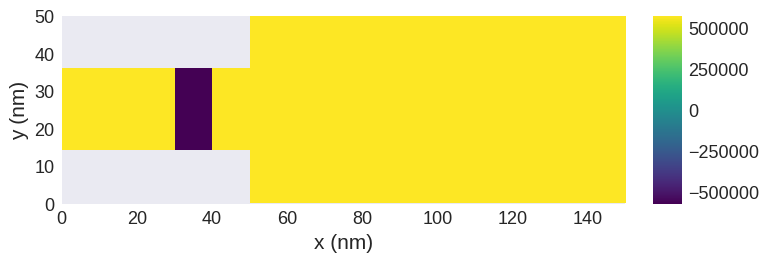

In [1]:
import oommfc as oc
import discretisedfield as df
import micromagneticmodel as mm

Ms = 5.8e5  # saturation magnetisation (A/m)
A = 15e-12  # exchange energy constant (J/)
D = 3e-3  # Dzyaloshinkii-Moriya energy constant (J/m**2)
K = 0.5e6  # uniaxial anisotropy constant (J/m**3)
u = (0, 0, 1)  # easy axis
gamma0 = 2.211e5  # gyromagnetic ratio (m/As)
alpha = 0.3  # Gilbert damping

system = mm.System(name='dw_pair_conversion')
system.energy = mm.Exchange(A=A) + mm.DMI(D=D, crystalclass='Cnv_z') + mm.UniaxialAnisotropy(K=K, u=u)
system.dynamics = mm.Precession(gamma0=2.211e5) + mm.Damping(alpha=alpha)

p1 = (0, 0, 0)
p2 = (150e-9, 50e-9, 2e-9)
cell = (2e-9, 2e-9, 2e-9)

region = df.Region(p1=p1, p2=p2)
mesh = df.Mesh(region=region, cell=cell)

def Ms_fun(pos):
    x, y, z = pos
    if x < 50e-9 and (y < 15e-9 or y > 35e-9):
        return 0
    else:
        return Ms
    
def m_init(pos):
    x, y, z = pos
    if 30e-9 < x < 40e-9:
        return (0.1, 0.1, -1)
    else:
        return (0.1, 0.1, 1)
    
system.m = df.Field(mesh, nvdim=3, value=m_init, norm=Ms_fun, valid="norm")

system.m.z.sel('z').mpl.scalar()

Running OOMMF (ExeOOMMFRunner)[2023/10/23 15:51]... (0.5 s)


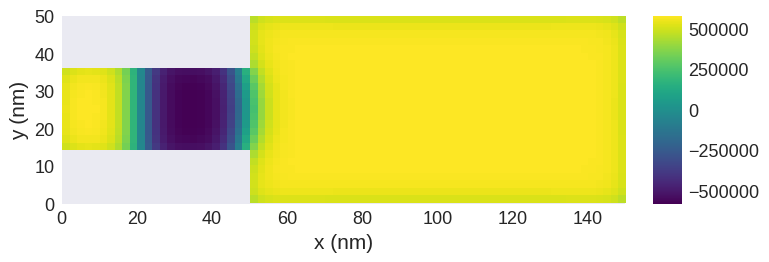

In [2]:
md = oc.MinDriver()
md.drive(system)

system.m.z.sel('z').mpl.scalar()

In [3]:
ux = 400  # velocity in x direction (m/s)
beta = 0.5  # non-adiabatic STT parameter

system.dynamics += mm.ZhangLi(u=ux, beta=beta)

Running OOMMF (ExeOOMMFRunner)[2023/10/23 15:51]... (2.1 s)


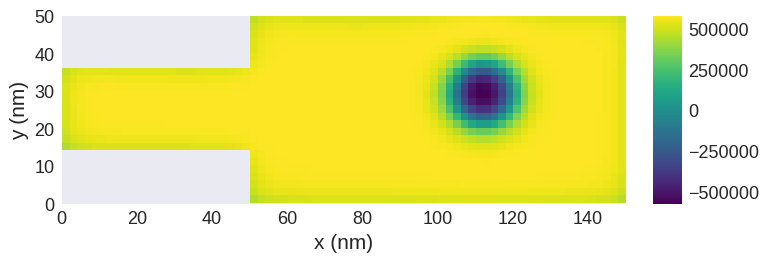

In [4]:
td = oc.TimeDriver()
td.drive(system, t=0.2e-9, n=200)

system.m.z.sel('z').mpl.scalar()

As a result, we got a skyrmion formed in the wider region.

We can use the `micromagneticdata` package to examine the time drive and create an interactive plot.

In [5]:
import micromagneticdata as md

data = md.Data(system.name)

# Use only the last time drive
time_drive = data[-1]

time_drive.hv(
    kdims=["x", "y"],
    scalar_kw={"clim": (-Ms, Ms), "cmap": "coolwarm"},
)

:DynamicMap   [t]
   :Overlay
      .Image.I       :Image   [x,y]   (field)
      .VectorField.I :VectorField   [x,y]   (angle,mag)